In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import scipy.linalg
import scipy.spatial.distance

import matplotlib.pyplot as plt
import seaborn as sb

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
DO_WHITENING = True
DO_CORAL = True
REG_PARAM = 1.0

# READ METADATA OF IMAGES (LEVEL 1)

In [3]:
featdir = "/home/jccaicedo/bbbc021/experiments/basic/02/validation/res4a_relu/"
meta = pd.read_csv("/home/jccaicedo/bbbc021/dp0.1/inputs/metadata/index.csv")

# LOAD SINGLE CELL FEATURES (LEVEL 2)

In [4]:
features = []
for i in tqdm(meta.index):
    filename = featdir + "{}_{}_{}.npz"
    filename = filename.format(meta.loc[i, "Metadata_Plate"], meta.loc[i, "Metadata_Well"], meta.loc[i, "Metadata_Site"])
    with open(filename, "rb") as data:
        info = np.load(data)
        features.append(info["f"])

100%|██████████| 3848/3848 [00:10<00:00, 352.59it/s]


In [5]:
total_single_cells = 0
for i in range(len(features)):
    total_single_cells += features[i].shape[1]
    
print("Total images",len(features),features[0].shape)
print("Total single cells:", total_single_cells)

Total images 3848 (128, 256)
Total single cells: 985088


# AGGREGATE INTO SITE LEVEL DATA (LEVEL 3)

In [6]:
site_level_data = []
site_level_features = []
for plate in tqdm(meta["Metadata_Plate"].unique()):
    m1 = meta["Metadata_Plate"] == plate
    wells = meta[m1]["Metadata_Well"].unique()
    for well in wells:
        result = meta.query("Metadata_Plate == '{}' and Metadata_Well == '{}'".format(plate, well))
        for i in result.index:
            num_features = features[i].shape[1]
            mean_profile = features[i].mean(axis=0)
            compound = result["compound"].unique()
            concentration = result["concentration"].unique()
            replicate = result["Replicate"].unique()
            moa = result["moa"].unique()
            if len(compound) > 1 or len(concentration) > 1 or len(moa) > 1:
                print(compound, concentration, moa)
            site_level_data.append(
                {
                    "Plate": plate,
                    "Well": well,
                    "Compound": compound[0],
                    "Concentration": concentration[0],
                    "Replicate": replicate[0],
                    "MOA": moa[0]
                }
            )
            site_level_features.append(mean_profile)

100%|██████████| 55/55 [00:04<00:00, 11.64it/s]


In [7]:
columns1 = ["Plate", "Well", "Compound", "Concentration", "MOA", "Batch", "Replicate"]
columns2 = [i for i in range(num_features)]
sites1 = pd.DataFrame(columns=columns1, data=site_level_data)
sites1["Batch"] = sites1["Plate"].apply(lambda x: x.split("_")[0])
sites2 = pd.DataFrame(columns=columns2, data=site_level_features)
sites = pd.concat([sites1, sites2], axis=1)

# TYPICAL VARIATION NORMALIZATION

In [8]:
def whitening_transform(X, lambda_, rotate=True):
    C = (1/X.shape[0]) * np.dot(X.T, X)
    s, V = scipy.linalg.eigh(C)
    D = np.diag( 1. / np.sqrt(s + lambda_) )
    W = np.dot(V, D)
    if rotate:
        W = np.dot(W, V.T)
    return W

def whiten(X, mu, W):
    return np.dot( X - mu, W)

In [9]:
feature_ids = [i for i in range(num_features)]
    
if DO_WHITENING:
    # Compute center of data around controls
    controls = sites["Compound"] == "DMSO"
    mean_ctl = sites.loc[controls, feature_ids].mean()

    # Whitening transform on controls
    all_controls_matrix = sites.loc[controls, feature_ids] - mean_ctl
    W = whitening_transform(all_controls_matrix, REG_PARAM, rotate=False)
    sites[feature_ids] = whiten(sites[feature_ids], mean_ctl, W)


Is the covariance close the the identity? False
261.2586319517223


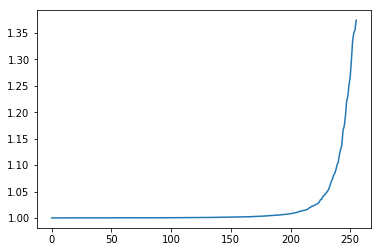

In [10]:
if DO_CORAL:
    # Compute target matrix
    CF = sites.loc[sites["Compound"] == "DMSO", feature_ids]
    C_target = (1/CF.shape[0]) * np.dot(CF.T, CF)
    print("Is the covariance close the the identity?", np.allclose(C_target, np.eye(C_target.shape[0])))

    I = REG_PARAM * np.eye(C_target.shape[0])
    C_target = np.real(scipy.linalg.sqrtm(C_target + I))
    
    print(np.sum(C_target))
    plt.plot(np.diag(C_target))
    #plt.imshow(C_target)

  0%|          | 0/10 [00:00<?, ?it/s]

Is the covariance close the the identity? False


 10%|█         | 1/10 [00:00<00:03,  2.39it/s]

(144, 256) 252.66779594986798
Is the covariance close the the identity? False


 20%|██        | 2/10 [00:00<00:03,  2.45it/s]

(144, 256) 252.72716865370933
Is the covariance close the the identity? False


 30%|███       | 3/10 [00:01<00:03,  2.33it/s]

(144, 256) 252.1996872616076
Is the covariance close the the identity? False


 40%|████      | 4/10 [00:01<00:02,  2.25it/s]

(144, 256) 253.53611268400306
Is the covariance close the the identity? False


 50%|█████     | 5/10 [00:02<00:02,  2.21it/s]

(144, 256) 253.08041929988892
Is the covariance close the the identity? False


 60%|██████    | 6/10 [00:02<00:01,  2.16it/s]

(120, 256) 250.07130237961366


 70%|███████   | 7/10 [00:03<00:01,  2.16it/s]

Is the covariance close the the identity? False
(72, 256) 254.78500271474732
Is the covariance close the the identity? False


 80%|████████  | 8/10 [00:03<00:00,  2.17it/s]

(144, 256) 253.13498856818498
Is the covariance close the the identity? False


 90%|█████████ | 9/10 [00:04<00:00,  2.09it/s]

(120, 256) 251.61799598984354
Is the covariance close the the identity? False


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

(144, 256) 253.943876016863


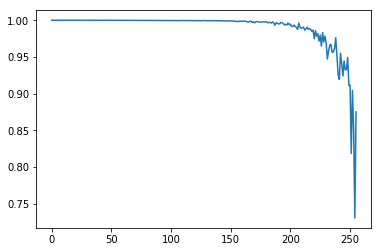

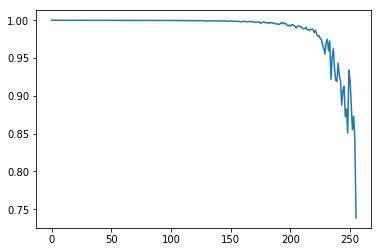

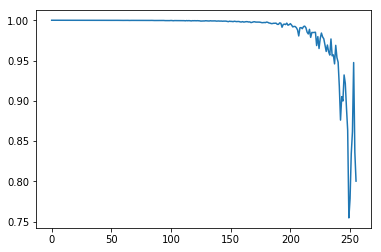

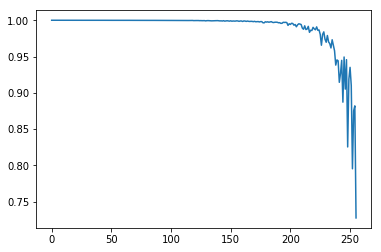

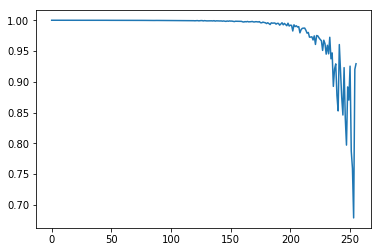

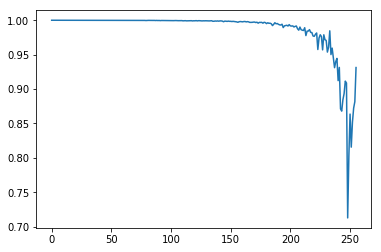

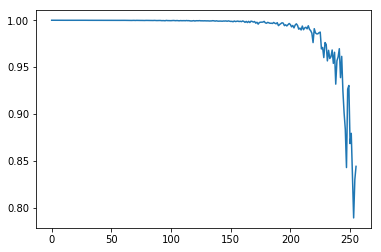

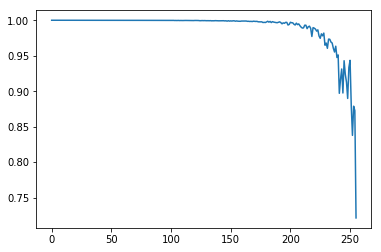

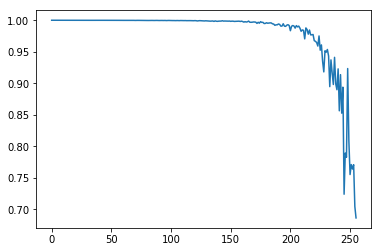

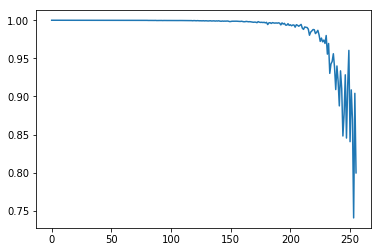

In [11]:
if DO_CORAL:
    aligned_feature_matrix = np.zeros_like(sites[feature_ids])
    plates = sites["Batch"].unique()
    for p in tqdm(plates):
        plate_data = sites[sites["Batch"] == p]
        plate_index = plate_data.index.tolist()
        is_control = plate_data.Compound == "DMSO"
        controls_index = plate_data[is_control].index

        controls_features = sites.iloc[controls_index][feature_ids]
        plate_features = sites.iloc[plate_index][feature_ids]
        
        C_source = (1/controls_features.shape[0]) * np.dot(controls_features.T, controls_features)
        print("Is the covariance close the the identity?", np.allclose(C_source, np.eye(C_source.shape[0])))
        C_source = scipy.linalg.inv( np.real( scipy.linalg.sqrtm(C_source + np.eye(C_source.shape[0])) ) )
        
        print(controls_features.shape, np.sum(C_source))
        plt.figure()
        plt.plot(np.diag(C_source))
        
        X = np.dot(np.dot(plate_features, C_source), C_target)
        aligned_feature_matrix[plate_index, :] = X
        
    sites[feature_ids] = aligned_feature_matrix

# AGGREGATE INTO WELL DATA (LEVEL 4)

In [12]:
# Prepare MOA class IDs
moas = sites["MOA"].unique()
moa_to_id = {moas[i]:i for i in range(len(moas))}
id_to_moas = {moa_to_id[i]:i for i in moa_to_id.keys()}

# Collapse well data
wells = sites.groupby(["Plate", "Well", "Compound", "Concentration", "MOA"]).mean().reset_index()
wells = wells[wells["Compound"] != "DMSO"]
wells = wells[wells["Compound"] != "taxol"]
wells["MOA_class"] = wells["MOA"].apply(lambda x: moa_to_id[x])

# AGGREGATE INTO TREATMENTS (LEVEL 5)

In [13]:
treatments = sites.groupby(["Compound", "Concentration", "MOA"]).median().reset_index()
treatments = treatments.drop("Replicate", axis=1)
treatments = treatments[treatments["Compound"] != "DMSO"]
treatments["MOA_class"] = treatments["MOA"].apply(lambda x: moa_to_id[x])

In [14]:
treatments["Batch"] = ""
for i in treatments.index:
    result = sites.query("Compound == '{}' and Concentration == {}".format(treatments.loc[i,"Compound"], treatments.loc[i,"Concentration"]))
    treatments.loc[i,"Batch"] = ",".join(result["Batch"].unique())

# MOA CLASSIFICATION

## TREATMENT LEVEL - NOT SAME COMPOUND MATCHING

In [15]:
def knn(X, Y, T):
    neigh = KNeighborsClassifier(n_neighbors=1, algorithm="brute", metric="cosine")
    neigh.fit(X, Y)
    prediction = neigh.predict(T)
    return prediction[0]

def nsc(treatments):
    treatments["nsc"] = 0
    correct, total = 0, 0
    for i in treatments.index:
        # Leave one compound out
        training_data = treatments[treatments["Compound"] != treatments.loc[i, "Compound"]]
        test_data = np.asarray(treatments.loc[i, feature_ids]).reshape(1, -1)
        prediction = knn(training_data[feature_ids], training_data["MOA_class"], test_data)
        # Check prediction
        if treatments.loc[i, "MOA_class"] == prediction:
            correct += 1
            treatments.loc[i, "nsc"] = 1
        else:
            print(len(training_data), treatments.loc[i, "Compound"], treatments.loc[i, "Concentration"], treatments.loc[i, "MOA"], moas[prediction])
        total += 1
    print("NSC Accuracy: {} correct out of {} = {}".format(correct, total, correct/total) )
    
print(" >> TREATMENT LEVEL")
nsc(treatments)
#print(" >> WELL LEVEL")
#nsc(wells)

 >> TREATMENT LEVEL
101 ALLN 3.0 Protein degradation DNA damage
102 colchicine 0.03 Microtubule destabilizers DNA replication
102 cytochalasin D 0.3 Actin disruptors Protein degradation
NSC Accuracy: 100 correct out of 103 = 0.970873786407767


## TREATMENT LEVEL - NOT SAME COMPOUND, NOT SAME BATCH

In [16]:
def nscb(treatments):
    treatments["nscb"] = 1
    # Cholesterol-lowering and Kinase inhibitors are only in one batch
    valid_treatments = treatments[~treatments["MOA"].isin(["Cholesterol-lowering","Kinase inhibitors"])]
    
    correct, total = 0, 0
    for i in valid_treatments.index:
        # Leave same compound and batch out
        mask1 = valid_treatments["Compound"] != valid_treatments.loc[i, "Compound"]
        mask2 = valid_treatments["Batch"] != valid_treatments.loc[i, "Batch"]
        training_data = valid_treatments[mask1 & mask2]
        test_data = np.asarray(valid_treatments.loc[i, feature_ids]).reshape(1, -1)
        prediction = knn(training_data[feature_ids], training_data["MOA_class"], test_data)
        # Check prediction
        if valid_treatments.loc[i, "MOA_class"] == prediction:
            correct += 1
        else:
            print(len(training_data), 
                  valid_treatments.loc[i, "Compound"], 
                  valid_treatments.loc[i, "Concentration"], 
                  valid_treatments.loc[i, "MOA"], 
                  moas[prediction])
            treatments.loc[i, "nscb"] = 0
        total += 1
    print("NSCB Accuracy: {} correct out of {} = {}".format(correct, total, correct/total) )
    
print(" >> TREATMENT LEVEL")
nscb(treatments)

 >> TREATMENT LEVEL
86 ALLN 3.0 Protein degradation DNA damage
86 ALLN 100.0 Protein degradation Microtubule destabilizers
86 MG-132 3.0 Protein degradation Protein synthesis
74 colchicine 0.03 Microtubule destabilizers DNA replication
74 cytochalasin B 30.0 Actin disruptors Protein synthesis
86 cytochalasin D 0.3 Actin disruptors Microtubule destabilizers
63 etoposide 10.0 DNA damage Protein degradation
74 latrunculin B 1.0 Actin disruptors Epithelial
74 latrunculin B 3.0 Actin disruptors Eg5 inhibitors
63 vincristine 0.003 Microtubule destabilizers Microtubule stabilizers
63 vincristine 1.0 Microtubule destabilizers Eg5 inhibitors
63 vincristine 3.0 Microtubule destabilizers Microtubule stabilizers
NSCB Accuracy: 80 correct out of 92 = 0.8695652173913043


# VISUALIZATION OF PROFILES

In [17]:
treated_wells = wells[~wells["Compound"].isin(["DMSO"])]#, "taxol"])]
treated_wells["nsc"] = -1
treated_wells["level"] = "wells"
treatments["level"] = "treatments"
embeddings = np.concatenate( [treated_wells[feature_ids], treatments[feature_ids]] )
C = scipy.spatial.distance.cdist(embeddings, embeddings, 'cosine')
tsne = TSNE()
projection = tsne.fit_transform(C)

In [18]:
df = pd.DataFrame(dict(
    x=projection[:,0],
    y=projection[:,1],
    moa=pd.concat([treated_wells["MOA"], treatments["MOA"]]),
    batch=pd.concat([treated_wells["Plate"].apply(lambda x: x.split("_")[0]), treatments["Batch"]]),
    compound=pd.concat([treated_wells["Compound"], treatments["Compound"]]),
    correct=pd.concat([treated_wells["nsc"],treatments["nsc"]]),
    level=pd.concat([treated_wells["level"],treatments["level"]])
))

In [19]:
df = df[df.level == "treatments"]

/home/jccaicedo/.local/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


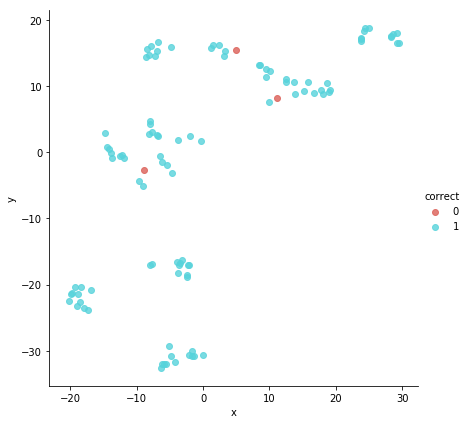

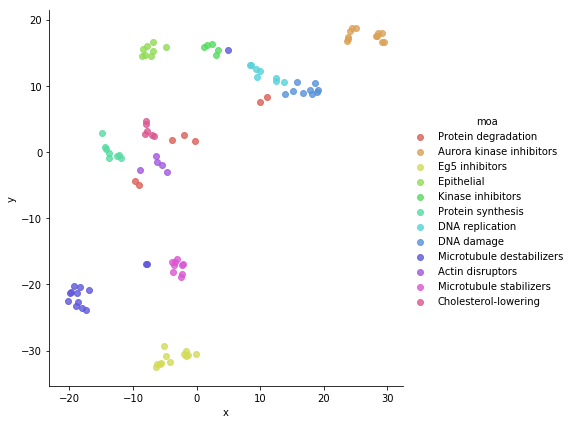

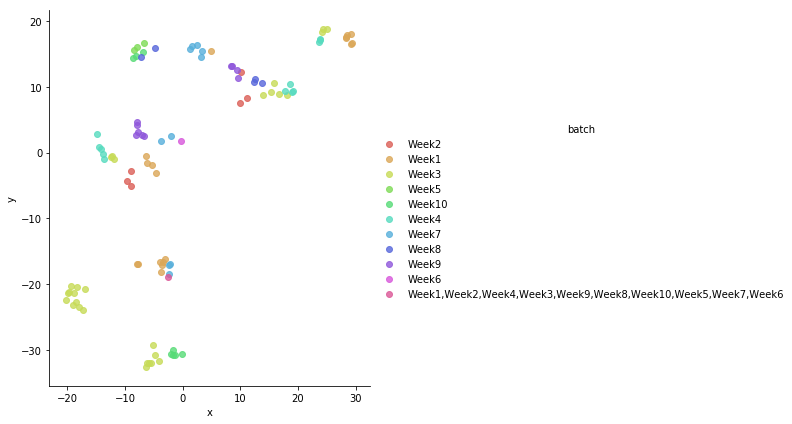

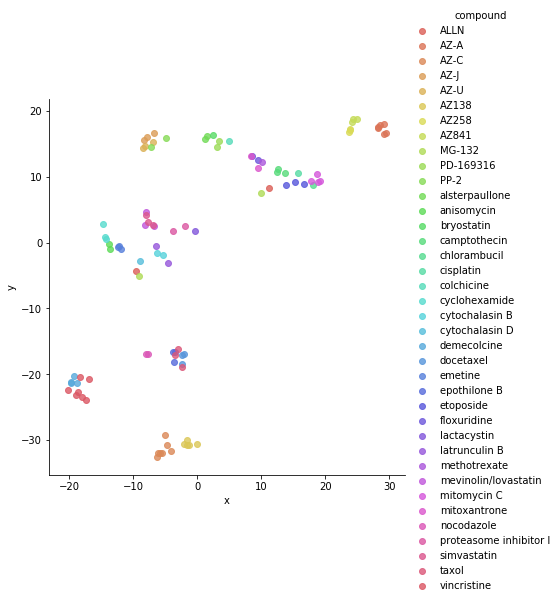

In [20]:
plt.figure()
sb.lmplot('x', 'y', data=df, hue='correct', fit_reg=False, palette="hls", size=6)

plt.figure()
sb.lmplot('x', 'y', data=df, hue='moa', fit_reg=False, palette="hls", size=6)

plt.figure()
sb.lmplot('x', 'y', data=df, hue='batch', fit_reg=False, palette="hls", size=6)

plt.figure()
sb.lmplot('x', 'y', data=df, hue='compound', fit_reg=False, palette="hls", size=6)